# 八 支持向量机SVM

## 1 自定义实现SVM

数据集大小： 200


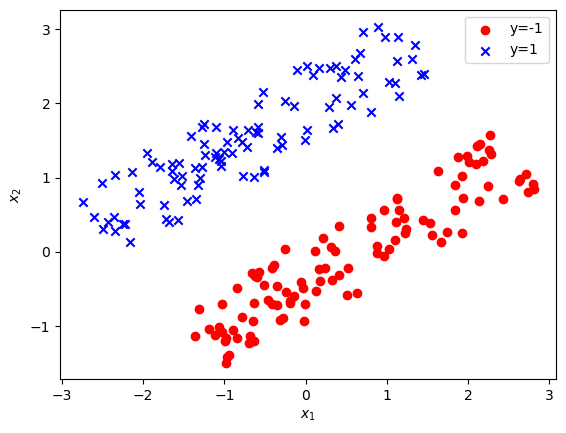

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from tqdm import tqdm, trange

data = np.loadtxt('./data/ch08/linear.csv', delimiter=',')
print('数据集大小：', len(data))
x = data[:, :2]
y = data[:, 2]

# 数据集可视化
plt.figure()
plt.scatter(x[y == -1, 0], x[y == -1, 1], color='red', label='y=-1')
plt.scatter(x[y == 1, 0], x[y == 1, 1], color='blue', marker='x', label='y=1')
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.legend()
plt.show()

In [2]:
def SMO(x, y, ker, C, max_iter):
    '''
    SMO算法
    x，y：样本的值和类别
    ker：核函数，与线性回归中核函数的含义相同
    C：惩罚系数
    max_iter：最大迭代次数
    '''
    # 初始化参数
    m = x.shape[0]
    alpha = np.zeros(m)
        
    # 预先计算所有向量的两两内积，减少重复计算
    K = np.zeros((m, m))
    for i in range(m):
        for j in range(m):
            K[i, j] = ker(x[i], x[j])
    
    for l in trange(max_iter):
        # 开始迭代
        for i in range(m):
            # 有m个参数，每一轮迭代中依次更新
            # 固定参数alpha_i与另一个随机参数alpha_j，并且保证i与j不相等
            j = np.random.choice([l for l in range(m) if l != i])
            
            # 用-b/2a更新alpha_i的值
            eta = K[j, j] + K[i, i] - 2 * K[i, j] # 分母
            e_i = np.sum(y * alpha * K[:, i]) - y[i] # 分子
            e_j = np.sum(y * alpha * K[:, j]) - y[j]
            alpha_i = alpha[i] + y[i] * (e_j - e_i) / (eta + 1e-5) # 防止除以0
            zeta = alpha[i] * y[i] + alpha[j] * y[j]

            # 将alpha_i和对应的alpha_j保持在[0,C]区间
            # 0 <= (zeta - y_j * alpha_j) / y_i <= C
            if y[i] == y[j]:
                lower = max(0, zeta / y[i] - C)
                upper = min(C, zeta / y[i])
            else:
                lower = max(0, zeta / y[i])
                upper = min(C, zeta / y[i] + C)
            alpha_i = np.clip(alpha_i, lower, upper)
            alpha_j = (zeta - y[i] * alpha_i) / y[j]
            
            # 更新参数
            alpha[i], alpha[j] = alpha_i, alpha_j

    return alpha

In [3]:
# 设置超参数
C = 1e8 # 由于数据集完全线性可分，我们不引入松弛变量
max_iter = 1000
np.random.seed(0)

alpha = SMO(x, y, ker=np.inner, C=C, max_iter=max_iter)

100%|██████████| 1000/1000 [00:05<00:00, 171.75it/s]


支持向量个数： 6
参数： [-1.0211867   1.66445549] -1.3127020970395462


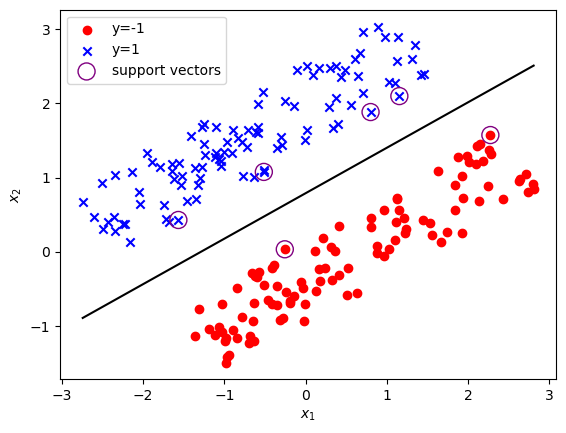

In [4]:
# 用alpha计算w，b和支持向量
sup_idx = alpha > 1e-5 # 支持向量的系数不为零
print('支持向量个数：', np.sum(sup_idx))
w = np.sum((alpha[sup_idx] * y[sup_idx]).reshape(-1, 1) * x[sup_idx], axis=0)
wx = x @ w.reshape(-1, 1)
b = -0.5 * (np.max(wx[y == -1]) + np.min(wx[y == 1]))
print('参数：', w, b)

# 绘图
X = np.linspace(np.min(x[:, 0]), np.max(x[:, 0]), 100)
Y = -(w[0] * X + b) / (w[1] + 1e-5)
plt.figure()
plt.scatter(x[y == -1, 0], x[y == -1, 1], color='red', label='y=-1')
plt.scatter(x[y == 1, 0], x[y == 1, 1], marker='x', color='blue', label='y=1')
plt.plot(X, Y, color='black')
# 用圆圈标记出支持向量
plt.scatter(x[sup_idx, 0], x[sup_idx, 1], marker='o', color='none', 
    edgecolor='purple', s=150, label='support vectors')
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.legend()
plt.show()

数据集大小： 194


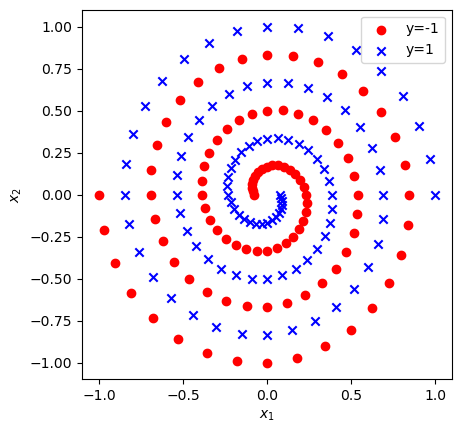

In [5]:
data = np.loadtxt('./data/ch08/spiral.csv', delimiter=',')
print('数据集大小：', len(data))
x = data[:, :2]
y = data[:, 2]

# 数据集可视化
plt.figure()
plt.scatter(x[y == -1, 0], x[y == -1, 1], color='red', label='y=-1')
plt.scatter(x[y == 1, 0], x[y == 1, 1], marker='x', color='blue', label='y=1')
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.legend()
plt.axis('square')
plt.show()

In [6]:
# 简单多项式核
def simple_poly_kernel(d):
    def k(x, y): 
        return np.inner(x, y) ** d
    return k

# RBF核
def rbf_kernel(sigma):
    def k(x, y):
        return np.exp(-np.inner(x - y, x - y) / (2.0 * sigma ** 2))
    return k

# 余弦相似度核
def cos_kernel(x, y):
    return np.inner(x, y) / np.linalg.norm(x, 2) / np.linalg.norm(y, 2)

# sigmoid核
def sigmoid_kernel(beta, c):
    def k(x, y):
        return np.tanh(beta * np.inner(x, y) + c)
    return k

核函数： Poly(3)


100%|██████████| 500/500 [00:02<00:00, 181.72it/s]


核函数： RBF(0.1)


100%|██████████| 500/500 [00:02<00:00, 179.18it/s]


核函数： Cos


100%|██████████| 500/500 [00:02<00:00, 180.10it/s]


核函数： Sigmoid(1,-1)


100%|██████████| 500/500 [00:02<00:00, 178.77it/s]


<Figure size 640x480 with 0 Axes>

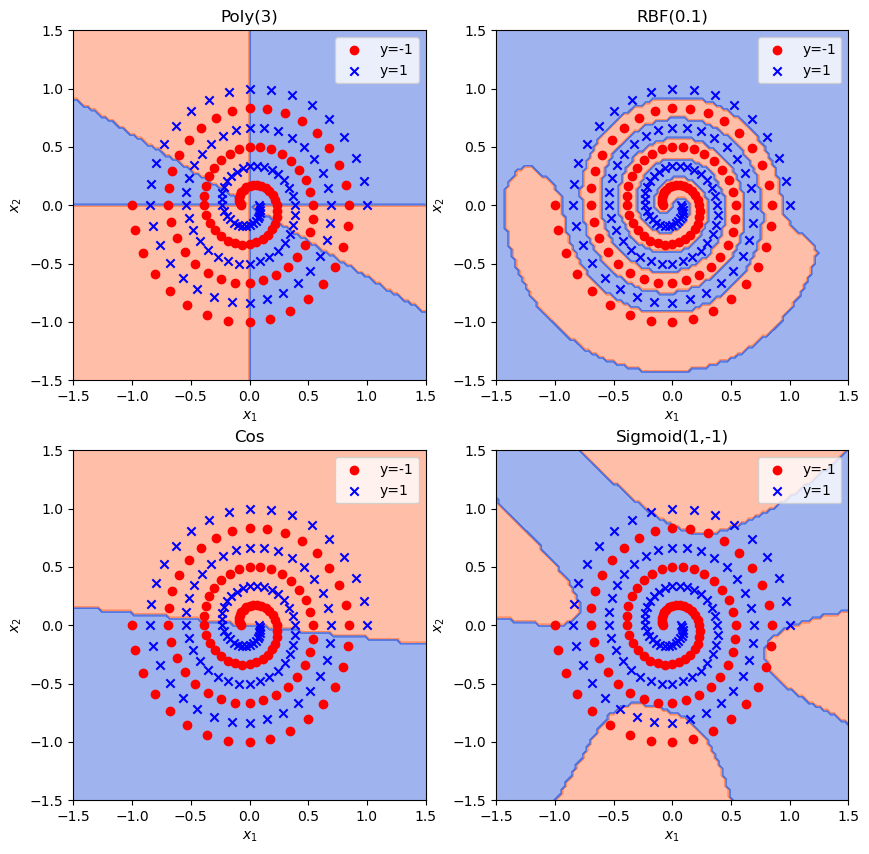

In [7]:
kernels = [
    simple_poly_kernel(3), 
    rbf_kernel(0.1), 
    cos_kernel, 
    sigmoid_kernel(1, -1)
]
ker_names = ['Poly(3)', 'RBF(0.1)', 'Cos', 'Sigmoid(1,-1)']
C = 1e8
max_iter = 500

# 绘图准备，构造网格
plt.figure()
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
axs = axs.flatten()
cmap = ListedColormap(['coral', 'royalblue'])

# 开始求解 SVM
for i in range(len(kernels)):
    print('核函数：', ker_names[i])
    alpha = SMO(x, y, kernels[i], C=C, max_iter=max_iter)
    sup_idx = alpha > 1e-5 # 支持向量的系数不为零
    sup_x = x[sup_idx] # 支持向量
    sup_y = y[sup_idx]
    sup_alpha = alpha[sup_idx]

    # 用支持向量计算 w^T*x
    def wx(x_new):
        s = 0
        for xi, yi, ai in zip(sup_x, sup_y, sup_alpha):
            s += yi * ai * kernels[i](xi, x_new)
        return s

    # 计算b*
    neg = [wx(xi) for xi in sup_x[sup_y == -1]]
    pos = [wx(xi) for xi in sup_x[sup_y == 1]]
    b = -0.5 * (np.max(neg) + np.min(pos))

    # 构造网格并用 SVM 预测分类
    G = np.linspace(-1.5, 1.5, 100)
    G = np.meshgrid(G, G)
    X = np.array([G[0].flatten(), G[1].flatten()]).T # 转换为每行一个向量的形式
    Y = np.array([wx(xi) + b for xi in X])
    Y[Y < 0] = -1
    Y[Y >= 0] = 1
    Y = Y.reshape(G[0].shape)
    axs[i].contourf(G[0], G[1], Y, cmap=cmap, alpha=0.5)
    # 绘制原数据集的点
    axs[i].scatter(x[y == -1, 0], x[y == -1, 1], color='red', label='y=-1')
    axs[i].scatter(x[y == 1, 0], x[y == 1, 1], marker='x', color='blue', label='y=1')
    axs[i].set_title(ker_names[i])
    axs[i].set_xlabel(r'$x_1$')
    axs[i].set_ylabel(r'$x_2$')
    axs[i].legend()

plt.show()

## 2 sklearn实现SVC

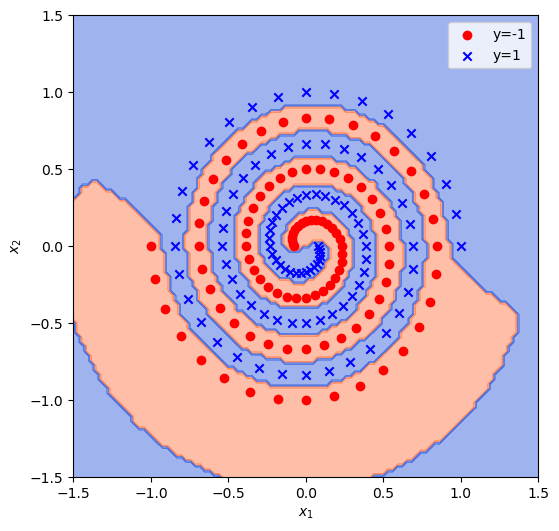

In [8]:
# 从sklearn.svm中导入SVM分类器
from sklearn.svm import SVC

# 定义SVM模型，包括定义使用的核函数与参数信息
model = SVC(kernel='rbf', gamma=50, tol=1e-6)
model.fit(x, y)

# 绘制结果
fig = plt.figure(figsize=(6,6))
G = np.linspace(-1.5, 1.5, 100)
G = np.meshgrid(G, G)
X = np.array([G[0].flatten(), G[1].flatten()]).T # 转换为每行一个向量的形式
Y = model.predict(X)
Y = Y.reshape(G[0].shape)
plt.contourf(G[0], G[1], Y, cmap=cmap, alpha=0.5)
# 绘制原数据集的点
plt.scatter(x[y == -1, 0], x[y == -1, 1], color='red', label='y=-1')
plt.scatter(x[y == 1, 0], x[y == 1, 1], marker='x', color='blue', label='y=1')
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.legend()
plt.show()